# Intro / Goals / Context


## Goal: 

Predict the fare of taxi tours

Is this a meaningful goal, or some placeholder task to do something?

## Question to Public:

" What kind of feature do you think necessary to have?"

" Why is this a datascience question?"

  - Uncertainty about the driver


# Motivation for the workshop?


What makes spatial data special? 
What kind of novel problems we face by working with spatial data?

    
    * COMPUTING DISTANCES: understand the spatial data properties (e.g. lat/lon, geodesical view)
    
    * being able to VISUALISE these datasets
        * plot heat maps on geographical backgrounds
        
    * ROUNDING must respect the architecture of the city, roads and building (example: route tracing should turn around the buildings).
    
    
    
# Modelling

## Get data and make exploratory plots to clean it.

* Use Kepler on cleaned data and develop a nice intuition.

## Baseline Model 00 (SO + CM)

* Explain Euclidean distance
* predict fare using the Euclidean distance
    Fare ~ 1 + EuclideanDistance
* Discuss what is the problem with the Euclidean distance.
    * TEACHING: Different types of distances
    * Have function definitions for different types of distances, explain code.
* Run the same model with different types of distances, and evaluate how much better the model becomes...
    Fare ~ 1 + X_Distance
    
## Updated Model 01 (EJ)

* use H3 hexagones as categorical features with the idea of capturing systematic variations in locations e.g. center of the city being more busy in general in comparison to a tour along the periphery of the city.


* demand within an hexagon.


## Updated Model 02 

* Daily seasonality: hour of the day as a feature with the idea 
    
    
## Updated Model 03 (CM)

Use https://osmcode.org/pyosmium/ to get route features.

* Get features from the route between pickup and dropoff
  ** # of traffic lights
  ** Allowed speed limit
  ** Number of lanes
  ** Number of hard lefts


## DISCUSSION

how to incorporate traffic information?


# (QUESTIONS for us) /

* do we want to train the model on all train data: Memory considerations


* Why is this task meaningful? 
    ** A simple rule is generating these data, why do we need data science to recover a known rule?
    
    ** how is what we want to do different than applying the rule that generates taxi fares?
    
    
* Are we going to train the model on the fly? If so, how long does it to fit it to 50 millions data points.


    

In [0]:
# %pip install pyproj

In [24]:
# libraries

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler

from utils.osrm_router.OSRMFramework import OSRMFramework
from utils.visualisation.lines import plot_linestring

###### constants
TARGET = 'fare_amount'
OSRM_PATH = 'localhost:5000'


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/caiomiyashiro/geospatial_data_analysis/master/data/sample_100000.csv')
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
display(df.head())
display(df.dtypes)


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,8.1,2009-01-23 07:28:00,-73.996070,40.732605,-73.980675,40.761864,1
1,9.0,2014-01-04 21:11:00,-73.977640,40.752346,-73.970390,40.768867,2
2,6.5,2015-06-22 01:54:24,-74.000080,40.728610,-73.988730,40.722170,6
3,4.5,2010-11-24 12:46:52,-73.962685,40.775646,-73.957436,40.777767,1
4,4.5,2011-11-01 02:19:34,-73.996300,40.753600,-73.998800,40.761100,1


fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
dtype: object

# Split training and testing before analysis

In [4]:
def split_training_test(df, target=TARGET, test_size=0.2):
    X = df.drop(TARGET, axis=1)
    y = df[TARGET]
    return train_test_split(X, y, test_size=test_size, random_state=0) 

def join_Xy(df, target, target_str=TARGET):
    df_ = df.copy()
    df_[target_str] = target
    return df_

def get_initial_training_testing_set(df):
    X_train, X_test, y_train, y_test = split_training_test(df)
    print(f'Shape X_train {X_train.shape}')
    print(f'Shape X_test {X_test.shape}')

    # join target for easier exploratory analysis
    df_train = join_Xy(X_train, y_train)
    df_test = join_Xy(X_test, y_test)
    return df_train, df_test

df_train, df_test = get_initial_training_testing_set(df)

Shape X_train (80000, 6)
Shape X_test (20000, 6)


# Exploratory Analysis

* latitudes/longitudes 0
* check points on the map - maybe find new york shapefile and remove points outside polygon
* Questions to look at kepler?
* Some trips, like to/from an airport, are fixed fee.

In [5]:
df_train.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
10382,2009-02-03 08:52:00,-73.97087,40.788616,-73.965706,40.774487,1,6.9
73171,2010-04-22 20:14:00,-73.97037,40.761692,-73.803375,40.762497,5,29.7
30938,2012-01-14 12:45:11,-73.97719,40.784420,-73.996500,40.748596,1,13.3
99310,2010-08-06 15:03:00,-73.97955,40.761967,-73.987240,40.755240,3,7.7
58959,2012-04-04 01:09:20,-73.98612,40.757550,-73.994470,40.758965,1,4.1


# Model 00 - Euclidean Distance

## Start experiment tracking

In [6]:
iteration_results = {}

In [7]:
def euclidean_distance(x1, y1, x2, y2):
    return (((x2-x1)**2 + (y2-y1)**2)**(1/2))

# Show how unrealistic it is, IF it's unrealisic
df_train['euclidean_dist'] = euclidean_distance(df_train['pickup_latitude'], df_train['dropoff_latitude'], 
                                                   df_train['pickup_longitude'], df_train['dropoff_longitude'])

df_train.head(3)

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,euclidean_dist
10382,2009-02-03 08:52:00,-73.97087,40.788616,-73.965706,40.774487,1,6.9,162.280780
73171,2010-04-22 20:14:00,-73.97037,40.761692,-73.803375,40.762497,5,29.7,162.138167
30938,2012-01-14 12:45:11,-73.97719,40.784420,-73.996500,40.748596,1,13.3,162.285749


In [8]:
def standardize_features(df):
    df_copy = df.copy()
    col_names = df_copy.columns
    ixs = df_copy.index
    return pd.DataFrame(StandardScaler().fit_transform(df_copy), columns=col_names, index=ixs)

def pre_processing_pipeline_1(df, target_col=TARGET,
                              pickup_latitude='pickup_latitude', dropoff_latitude='dropoff_latitude', 
                              pickup_longitude='pickup_longitude', dropoff_longitude='dropoff_longitude'):
  
    EUCLIDEAN_FEAT = 'euclidean_dist'
    FEATURES = [EUCLIDEAN_FEAT]

    df_copy = df.copy()
    df_copy[EUCLIDEAN_FEAT] = euclidean_distance(df_copy[pickup_latitude], df_copy[dropoff_latitude], 
                                                 df_copy[pickup_longitude], df_copy[dropoff_longitude])
    # in the EDA, we probably treat the nulls, so for now, just drop them
    df_copy = df_copy.dropna()

    df_res = standardize_features(df_copy[FEATURES])
    df_res[target_col] = df_copy[target_col]
    return df_res

df_train = pre_processing_pipeline_1(df_train)
df_test = pre_processing_pipeline_1(df_test)



In [9]:
model = LinearRegression()
model.fit(df_train.drop(TARGET, axis=1), df_train[TARGET])

y_test_predicted = model.predict(df_test.drop(TARGET, axis=1))

Mean Absolute Error: 5.9948500667004065


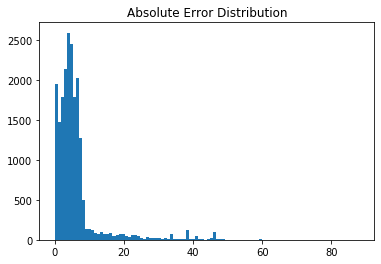

In [10]:
def print_evaluation(y_obs, y_pred, max_lim_y=100, return_errors=True):
    mae_hist = np.abs(y_test_predicted - df_test[TARGET])
    plt.hist(mae_hist[y_obs < max_lim_y], bins=100)
    plt.title('Absolute Error Distribution');

    if(return_errors == True):
        return mae_hist

#####
mae = mean_absolute_error(df_test[TARGET], y_test_predicted)
iteration_results['exp_1_mae'] = mae
print(f'Mean Absolute Error: {mae}')

print_evaluation(df_test[TARGET], y_test_predicted, return_errors=False)

## Experimenting on different types of distance
### Haversine - Explain
### Great Circle - Explain


In [11]:
df_train, df_test = get_initial_training_testing_set(df)

Shape X_train (80000, 6)
Shape X_test (20000, 6)


In [14]:
def lat_longs2radians(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    return lon1, lat1, lon2, lat2

def haversine_distance(lat1, lat2, lon1, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.

    """
    lon1, lat1, lon2, lat2 = lat_longs2radians(lon1, lat1, lon2, lat2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

# TODO: manhattan with lat lon has NOT worked - see attempt below
# def manhattan_distance(lon1, lat1, lon2, lat2):
#   lon1, lat1, lon2, lat2 = lat_longs2radians(lon1, lat1, lon2, lat2)
#   dlon = np.abs(lon2 - lon1)
#   dlat = np.abs(lat2 - lat1)
#   return dlon + dlat

df_train['haversine_dist'] = haversine_distance(df_train['pickup_latitude'], df_train['dropoff_latitude'], 
                                                   df_train['pickup_longitude'], df_train['dropoff_longitude'])


# df_train['manhattan_dist'] = manhattan_distance(df_train['pickup_latitude'], df_train['dropoff_latitude'], 
#                                                    df_train['pickup_longitude'], df_train['dropoff_longitude'])

df_train.head(3)


,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,haversine_dist
10382,2009-02-03 08:52:00,-73.97087,40.788616,-73.965706,40.774487,1,6.9,1.629105
73171,2010-04-22 20:14:00,-73.97037,40.761692,-73.803375,40.762497,5,29.7,14.056115
30938,2012-01-14 12:45:11,-73.97719,40.784420,-73.996500,40.748596,1,13.3,4.299907


In [15]:
# trying to convert to UTM and use traditional euclidean space to calculate manhattan BUT IT DIDN'T WORK



# from pyproj import Proj, transform

# inProj = Proj(init='epsg:4326')  # lat lon
# outProj = Proj(init='epsg:3857') # UTM

# lat_pickup_utm, lon_pickup_utm = transform(inProj,outProj,df_train['pickup_latitude'].values, df_train['pickup_longitude'].values)
# lat_dropoff_utm, lon_dropoff_utm = transform(inProj,outProj,df_train['dropoff_latitude'].values, df_train['dropoff_longitude'].values)

# df_train['manhattan_dist'] = np_manhattan(np.array(lat_pickup_utm), np.array(lat_dropoff_utm), 
#                                           np.array(lon_pickup_utm), np.array(lon_dropoff_utm))

In [16]:
def pre_processing_pipeline_2(df, target_col=TARGET, 
                              pickup_latitude='pickup_latitude', dropoff_latitude='dropoff_latitude', 
                              pickup_longitude='pickup_longitude', dropoff_longitude='dropoff_longitude'):
    EUCLIDEAN_FEAT = 'euclidean_dist'
    HAVERSINE_FEAT = 'haversine_dist'
    # MANHATTAN_FEAT = 'manhattan_dist'
    FEATURES = [EUCLIDEAN_FEAT, HAVERSINE_FEAT] #, MANHATTAN_FEAT - #not returning MANHATTAN_FEAT because it's wrong

    df_copy = df.copy()

    df_copy[EUCLIDEAN_FEAT] = euclidean_distance(df_copy[pickup_latitude], df_copy[dropoff_latitude], 
                                              df_copy[pickup_longitude], df_copy[dropoff_longitude])
    df_copy[HAVERSINE_FEAT] = haversine_distance(df_copy[pickup_latitude], df_copy[dropoff_latitude], 
                                              df_copy[pickup_longitude], df_copy[dropoff_longitude])
    # df_copy[MANHATTAN_FEAT] = manhattan_distance(df_copy[pickup_latitude], df_copy[dropoff_latitude], 
    #                                         df_copy[pickup_longitude], df_copy[dropoff_longitude])

    # in the EDA, we probably treat the nulls, so for now, just drop them
    df_copy = df_copy.dropna()

    df_res = standardize_features(df_copy[FEATURES])
    df_res[target_col] = df_copy[target_col]
    return df_res

df_train = pre_processing_pipeline_2(df_train)
df_test = pre_processing_pipeline_2(df_test)


In [18]:
model = LinearRegression()
model.fit(df_train.drop(TARGET, axis=1), df_train[TARGET])

y_test_predicted = model.predict(df_test.drop(TARGET, axis=1))

Mean Absolute Error: 5.995354003797517


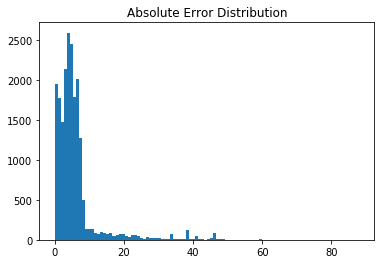

In [19]:
#####
mae = mean_absolute_error(df_test[TARGET], y_test_predicted)
iteration_results['exp_2_mae'] = mae
print(f'Mean Absolute Error: {mae}')

print_evaluation(df_test[TARGET], y_test_predicted, return_errors=False)

In [20]:
iteration_results

{'exp_1_mae': 5.9948500667004065, 'exp_2_mae': 5.995354003797517}

# Creating a router - OSRM Router

## Calculate street distances and durations

## Setup

Setting local docker image for ORSM back-end - https://hub.docker.com/r/osrm/osrm-backend/

* wget http://download.geofabrik.de/north-america/us/new-york-latest.osm.pbf (file is ~200 Mb)

* Move file to your project folder

* docker run -t -v "${PWD}:/data" osrm/osrm-backend osrm-extract -p /opt/car.lua /data/new-york-latest.osm.pbf

* docker run -t -v "${PWD}:/data" osrm/osrm-backend osrm-partition /data/new-york-latest.osm.pbf

* docker run -t -v "${PWD}:/data" osrm/osrm-backend osrm-customize /data/new-york-latest.osm.pbf

* docker run -t -i -p 5000:5000 -v "${PWD}:/data" osrm/osrm-backend osrm-routed --algorithm mld /data/new-york-latest.osm.pbf

Example latitude longitude New Yeork: 13.435441, 52.489406 13.063544,52.391463

Test: curl "http://localhost:5000/route/v1/driving/13.435441,52.489406;13.063544,52.391463?steps=false&geometries=geojson"

In [25]:
lat1, lon1 = 52.489406, 13.435441
lat2, lon2 = 52.391463, 13.063544

osm = OSRMFramework('localhost:5000')
lat, lon, distance, duration = osm.route(lat1, lon1, lat2, lon2)

In [27]:
lon

[13.435441, -72.135158, -72.135158]